In [1]:
import numpy as np
import sys
sys.path.append(r'C:\Users\zhang\1_jupyter_code\1_Functions')
import matplotlib.pyplot as plt
from cal_ppp_dis import cal_ppp_distance as cal_dis
import copy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.font_manager import FontProperties

In [3]:
file_path = r'C:\Users\zhang\Desktop\md\linbo3\cal_e_xyz\2650cry_1000p_out.xyz'

In [4]:
def read_xyz_frames(file_path):
    frames = []
    current_frame = None

    with open(file_path, 'r') as file:
        lines = file.readlines()
        line_index = 0

        while line_index < len(lines):
            line = lines[line_index].strip()

            if line.isdigit():
                # 读取原子数
                if current_frame:
                    frames.append(current_frame)
                num_atoms = int(line)
                current_frame = {"num_atoms": num_atoms, "atoms": []}
                line_index += 2  # 跳过标题行 "Atoms"
            else:
                # 读取原子坐标
                if current_frame:
                    atom_data = line.split()
                    if len(atom_data) == 4:
                        element, x, y, z = atom_data
                        current_frame["atoms"].append({
                            "element": element,
                            "x": float(x),
                            "y": float(y),
                            "z": float(z)
                        })
                line_index += 1

        if current_frame:
            frames.append(current_frame)

    return frames

# 使用之前的frames列表
frames = read_xyz_frames(file_path)

# 找出最大的x、y和z值
max_x = max([max(frame["atoms"], key=lambda atom: atom["x"])["x"] for frame in frames])
max_y = max([max(frame["atoms"], key=lambda atom: atom["y"])["y"] for frame in frames])
max_z = max([max(frame["atoms"], key=lambda atom: atom["z"])["z"] for frame in frames])

print("Maximum X value:", max_x)
print("Maximum Y value:", max_y)
print("Maximum Z value:", max_z)


Maximum X value: 112.919096
Maximum Y value: 23.913397
Maximum Z value: 74.2824


In [5]:
frames_0 = copy.deepcopy(frames)

In [6]:
box_size = (max_x+0.01,max_y+0.01,max_z+0.01)

In [7]:
frames[0]['atoms'][20]

{'element': 'O', 'x': 28.328452, 'y': 21.224027, 'z': 31.05936}

In [8]:
 # 模拟中的周期性边界条件，假设每个维度的边界大小
box_size = np.array([max_x, max_y, max_z])  # 根据您的模拟设置
print(box_size)
print('frames length:',len(frames))

[112.919096  23.913397  74.2824  ]
frames length: 50


In [9]:
def get_xyz(frames_i,strat_frame_num,end_frame_num,ana_element):
    # 取出相对应的帧数 
    start_frame = frames_i[start_frame_num]
    end_frame = frames_i[end_frame_num]

    start_xyz, end_xyz = [],[]
    for i,j in zip(start_frame['atoms'], end_frame['atoms']):
        if i['element'] == ana_element:
            start_xyz.append([i['x'],i['y'],i['z']])
        if j['element'] == ana_element:
            end_xyz.append([j['x'],j['y'],j['z']])
    start_xyz, end_xyz = np.array(start_xyz), np.array(end_xyz)
    return start_xyz,end_xyz

In [10]:
def draw(start_frame_num,end_frame_num ,start_xyz,end_xyz,ana_element):

    # 设置全局字体属性
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 12

    # 设置图像大小
    fig = plt.figure(figsize=(12, 8))

    # 两帧原子的xyz数据，每一帧包含原子的位置信息
    frame1 = np.array(start_xyz)
    frame2 = np.array(end_xyz)

    # 盒子尺寸，假设为 [box_x, box_y, box_z]
    #box_size = [10.0, 10.0, 10.0]

    # 计算位移向量
    displacements = frame2[:, :2] - frame1[:, :2]

    # 考虑周期性边界条件，根据盒子尺寸修正位移
    for i in range(len(displacements)):
        for dim in range(2):  # 仅考虑 xy 平面
            if displacements[i, dim] > box_size[dim] / 2:
                displacements[i, dim] -= box_size[dim]
            elif displacements[i, dim] < -box_size[dim] / 2:
                displacements[i, dim] += box_size[dim]

    # 计算位移大小
    displacement_magnitude = np.linalg.norm(displacements, axis=1)

    # 计算位移方向
    displacement_direction = displacements / displacement_magnitude[:, np.newaxis]

    # 设置箭头的长度的倍数
    arrow_scale = 2  # 可以根据需要调整箭头的长度

    # 设置颜色映射范围，根据位移大小来映射颜色
    norm = Normalize(vmin=min(displacement_magnitude), vmax=max(displacement_magnitude))

    # 绘制位移图，将位移大小与箭头长度相乘
    plt.quiver(frame1[:, 0], frame1[:, 1], arrow_scale * displacement_direction[:, 0], arrow_scale * displacement_direction[:, 1], 
               arrow_scale * displacement_magnitude, cmap='viridis', angles='xy', scale_units='xy', scale=1, norm=norm)

    # 
    # 设置标题和轴标签的字体和字体大小，以及使用Times New Roman字体
    label_font = FontProperties(family='Times New Roman', style='normal', size=18, weight='bold')


    # 设置图形范围，根据盒子尺寸
    plt.xlim(0, box_size[0])
    plt.ylim(0, box_size[1])
    plt.xlabel('X (Å)',fontproperties=label_font)
    plt.ylabel('Y (Å)',fontproperties=label_font)
    # 添加颜色条

    title = 'The displacement of '+ ana_element+ ' : '+str(start_frame_num) +' - '+ str(end_frame_num)+' frame (8ns/1000frames) ' #(60ns/1000frames)
    plt.title(title, fontproperties=label_font)


    # 设置颜色条字体大小、粗细和字体族
    cbar = plt.colorbar(label='Displacement Magnitude')
    cbar.ax.tick_params(labelsize=12, width=2)  # 设置字体大小和粗细
    cbar.ax.yaxis.label.set_font_properties(FontProperties(family='Times New Roman', style='normal', size=12, weight='bold'))

    

    # 显示图形
    plt.show()
    print(len(frame1))

In [11]:
np.linspace(0,48,25)

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48.])

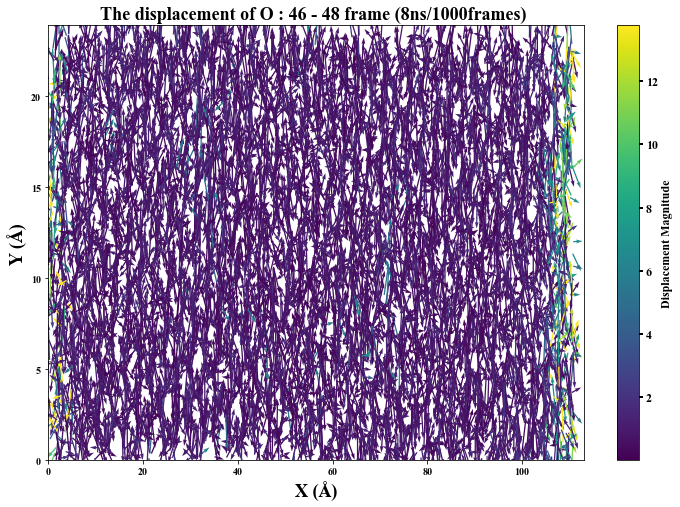

9000


In [12]:
# 分析两个帧数之间的msd  也就是位移差
start_frame_num = 46
end_frame_num = 48

ana_element = 'O'
####################
start_xyz,end_xyz = get_xyz(frames,start_frame_num,end_frame_num,ana_element)
draw(start_frame_num,end_frame_num ,start_xyz,end_xyz,ana_element)


start_frame_num = 0
end_frame_num = start_frame_num+2

ana_element = 'O'

# 设置一个位移大小的阈值 然后只画出位移小的部分

displacement_scale = 1.3


####################
start_xyz,end_xyz = get_xyz(frames,start_frame_num,end_frame_num,ana_element)

###################################

frame1 = np.array(start_xyz)
frame2 = np.array(end_xyz)
displacements = frame2[:, :2] - frame1[:, :2]
######
# 考虑周期性边界条件，根据盒子尺寸修正位移
for i in range(len(displacements)):
    for dim in range(2):  # 仅考虑 xy 平面
        if displacements[i, dim] > box_size[dim] / 2:
            displacements[i, dim] -= box_size[dim]
        elif displacements[i, dim] < -box_size[dim] / 2:
            displacements[i, dim] += box_size[dim]

# 计算位移大小
displacement_magnitude = np.linalg.norm(displacements, axis=1)
# 计算位移方向
displacement_direction = displacements / displacement_magnitude[:, np.newaxis]


# 初始化要删除的索引列表
indices_to_remove = []
# 筛选
for i,i_dis in enumerate(displacement_magnitude):
    if i_dis>displacement_scale:
        indices_to_remove.append(i)
# 在两个表中删除这个元素

# 删除小于 x 的元素
displacement_magnitude = np.delete(displacement_magnitude, indices_to_remove)

displacement_direction = np.delete(displacement_direction, indices_to_remove, axis=0)
frame1 = np.delete(frame1, indices_to_remove, axis=0)
frame2 = np.delete(frame2, indices_to_remove, axis=0)

print(len(frame1))

###############
# 设置全局字体属性
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
print(len(frame1))
    # 设置图像大小
fig = plt.figure(figsize=(12, 8))
    # 设置箭头的长度的倍数
arrow_scale = 2  # 可以根据需要调整箭头的长度

    # 设置颜色映射范围，根据位移大小来映射颜色
norm = Normalize(vmin=min(displacement_magnitude), vmax=max(displacement_magnitude))

    # 绘制位移图，将位移大小与箭头长度相乘
plt.quiver(frame1[:, 0], frame1[:, 1], arrow_scale * displacement_direction[:, 0], arrow_scale * displacement_direction[:, 1], 
               arrow_scale * displacement_magnitude, cmap='viridis', angles='xy', scale_units='xy', scale=1, norm=norm)

    # 
    # 设置标题和轴标签的字体和字体大小，以及使用Times New Roman字体
label_font = FontProperties(family='Times New Roman', style='normal', size=18, weight='bold')


    # 设置图形范围，根据盒子尺寸
plt.xlim(0, box_size[0])
plt.ylim(0, box_size[1])
plt.xlabel('X (Å)',fontproperties=label_font)
plt.ylabel('Y (Å)',fontproperties=label_font)
    # 添加颜色条

title = 'The displacement of '+ ana_element+ ' : '+str(start_frame_num) +' - '+ str(end_frame_num)+' frame (8ns/1000frames) ' #(60ns/1000frames)
plt.title(title, fontproperties=label_font)


    # 设置颜色条字体大小、粗细和字体族
cbar = plt.colorbar(label='Displacement Magnitude')
cbar.ax.tick_params(labelsize=12, width=2)  # 设置字体大小和粗细
cbar.ax.yaxis.label.set_font_properties(FontProperties(family='Times New Roman', style='normal', size=12, weight='bold'))

    

    # 显示图形
plt.show()
print(len(frame1))

In [13]:
# 分析的帧数 o-2,2-4...
start_num = np.linspace(0,46,24)
print(start_num)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46.]


In [14]:
import copy

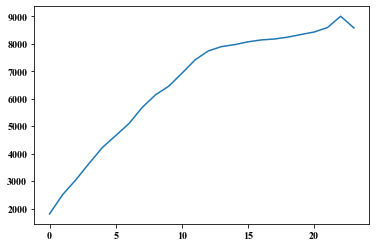

In [20]:
frames_0 = copy.deepcopy(frames)
#count = 0
# 分析元素 
ana_element = 'O'
# 设置一个位移大小的阈值 然后只画出位移小的部分
displacement_scale = 1.52
cry_atom_list = []
start_num = np.linspace(0,46,24)
# 调试好参数后，从循环中得到list 
for i in start_num:
    i = int(i)
   # print(i)
    ####################
    start_xyz,end_xyz = get_xyz(frames_0,i,i+2,ana_element)
###
    frame1 = copy.deepcopy(np.array(start_xyz))
    frame2 = copy.deepcopy(np.array(end_xyz))
    displacements = copy.deepcopy(frame2[:, :2] - frame1[:, :2])
    ######
    # 考虑周期性边界条件，根据盒子尺寸修正位移
    for i in range(len(displacements)):
        for dim in range(2):  # 仅考虑 xy 平面
            if displacements[i, dim] > box_size[dim] / 2:
                displacements[i, dim] -= box_size[dim]
            elif displacements[i, dim] < -box_size[dim] / 2:
                displacements[i, dim] += box_size[dim]

    # 计算位移大小 
    displacement_magnitude = np.linalg.norm(displacements, axis=1)
    # print(len(displacement_magnitude),'len dis')
    displacement_magnitude = copy.deepcopy(np.array([1e-4 if dis==0 else dis for dis in displacement_magnitude]))
    # 计算位移方向  
    #displacement_direction = copy.deepcopy(displacements / displacement_magnitude[:, np.newaxis])
    #print(len(displacement_direction))
    # 初始化要删除的索引列表
    indices_to_remove = []
    # 筛选
    for i,i_dis in enumerate(displacement_magnitude):
        if i_dis>displacement_scale:
            indices_to_remove.append(i)
    #print(len(indices_to_remove),'remove')
    # 在两个表中删除这个元素
    #print(len(indices_to_remove),'\n')
    # 删除小于 x 的元素
    #displacement_magnitude = np.delete(displacement_magnitude, indices_to_remove)

    #displacement_direction = np.delete(displacement_direction, indices_to_remove, axis=0)
    #frame1 = np.delete(frame1, indices_to_remove, axis=0)
    #print(len(frame1),'frame1')
    #frame2 = np.delete(frame2, indices_to_remove, axis=0)

    # 输出结果的大小
    #print(len(frame1) - len(indices_to_remove))
    cry_atom_list.append(len(frame1) - len(indices_to_remove))
    #cry_atom_list.append(len(frame1))
    #count += 1
    #if count==2:
        #dasd
plt.plot(range(len(cry_atom_list)),cry_atom_list)

In [21]:
print(cry_atom_list)

[1804, 2511, 3052, 3650, 4224, 4656, 5093, 5679, 6136, 6450, 6922, 7412, 7739, 7895, 7967, 8069, 8138, 8172, 8239, 8335, 8426, 8588, 9000, 8576]


In [17]:
np.save('C:\\Users\\zhang\\1_jupyter_code\\cal_cry\\2650k',np.array(cry_atom_list))

In [ ]:
 # 两帧原子的xyz数据，每一帧包含原子的位置信息
    frame1 = np.array(start_xyz)
    frame2 = np.array(end_xyz)

    # 盒子尺寸，假设为 [box_x, box_y, box_z]
    #box_size = [10.0, 10.0, 10.0]

    # 计算位移向量
    displacements = frame2[:, :2] - frame1[:, :2]

    # 考虑周期性边界条件，根据盒子尺寸修正位移
    for i in range(len(displacements)):
        for dim in range(2):  # 仅考虑 xy 平面
            if displacements[i, dim] > box_size[dim] / 2:
                displacements[i, dim] -= box_size[dim]
            elif displacements[i, dim] < -box_size[dim] / 2:
                displacements[i, dim] += box_size[dim]

    # 计算位移大小
    displacement_magnitude = np.linalg.norm(displacements, axis=1)

    # 计算位移方向
    displacement_direction = displacements / displacement_magnitude[:, np.newaxis]

    # 设置箭头的长度的倍数
    arrow_scale = 2  # 可以根据需要调整箭头的长度

    # 设置颜色映射范围，根据位移大小来映射颜色
    norm = Normalize(vmin=min(displacement_magnitude), vmax=max(displacement_magnitude))

    # 绘制位移图，将位移大小与箭头长度相乘
    plt.quiver(frame1[:, 0], frame1[:, 1], arrow_scale * displacement_direction[:, 0], arrow_scale * displacement_direction[:, 1], 
               arrow_scale * displacement_magnitude, cmap='viridis', angles='xy', scale_units='xy', scale=1, norm=norm)

    # 
    # 设置标题和轴标签的字体和字体大小，以及使用Times New Roman字体
    label_font = FontProperties(family='Times New Roman', style='normal', size=18, weight='bold')


    # 设置图形范围，根据盒子尺寸
    plt.xlim(0, box_size[0])
    plt.ylim(0, box_size[1])
    plt.xlabel('X (Å)',fontproperties=label_font)
    plt.ylabel('Y (Å)',fontproperties=label_font)
    # 添加颜色条

    title = 'The displacement of '+ ana_element+ ' : '+str(start_frame_num) +' - '+ str(end_frame_num)+' frame (8ns/1000frames) ' #(60ns/1000frames)
    plt.title(title, fontproperties=label_font)


    # 设置颜色条字体大小、粗细和字体族
    cbar = plt.colorbar(label='Displacement Magnitude')
    cbar.ax.tick_params(labelsize=12, width=2)  # 设置字体大小和粗细
    cbar.ax.yaxis.label.set_font_properties(FontProperties(family='Times New Roman', style='normal', size=12, weight='bold'))

    

    # 显示图形
    plt.show()


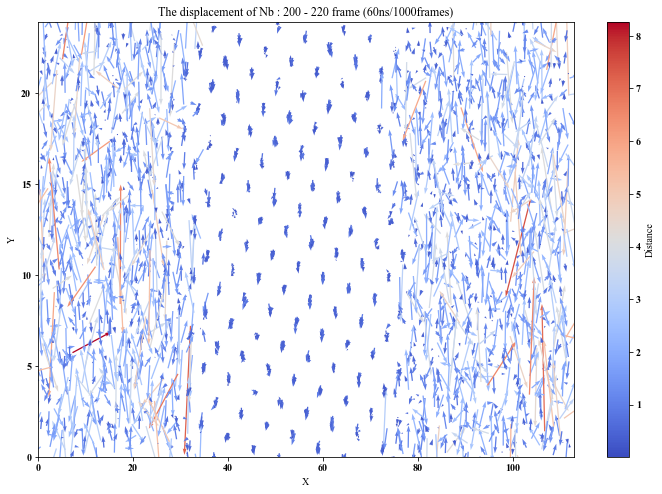

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 positions 是一个包含两个帧的原子位置的三维数组，每行代表一个原子的x、y、z坐标
frame1 = start_xyz
frame2 = end_xyz


# 计算三维原子位移矢量，考虑周期性边界条件
displacements = frame2 - frame1

# 计算位移矢量的投影到xy平面上，考虑周期性边界条件

# box_size = [x_size, y_size, z_size]  # 假设 box_size 包含x、y、z方向的单元格尺寸
x_size = box_size[0]
y_size=box_size[1]
z_size= box_size[2]


displacements[:, 0] = (displacements[:, 0] + 0.5 * box_size[0]) % box_size[0] - 0.5 * box_size[0]
displacements[:, 1] = (displacements[:, 1] + 0.5 * box_size[1]) % box_size[1] - 0.5 * box_size[1]

# 计算每个原子的距离，只考虑xy平面上的距离
distances = np.linalg.norm(displacements[:, :2], axis=1)

# 设置颜色映射，距离长的原子位移颜色越深
cmap = plt.get_cmap('coolwarm')
normalize = plt.Normalize(vmin=min(distances), vmax=max(distances))
colors = cmap(normalize(distances))

# 创建一个图形
plt.figure(figsize=(12, 8))
plt.quiver(frame1[:, 0], frame1[:, 1], displacements[:, 0], displacements[:, 1], color=colors, angles='xy', scale_units='xy', scale=1)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Distance')

# 设置坐标轴范围等其他属性
plt.xlim(0, x_size)
plt.ylim(0, y_size)
plt.xlabel('X')
plt.ylabel('Y')
title = 'The displacement of '+ ana_element+ ' : '+str(start_frame_num) +' - '+ str(end_frame_num)+' frame (60ns/1000frames)'
plt.title(title)

# 显示图形
plt.show()


In [14]:
# 取出相对应的帧数 
start_frame = frames[start_frame_num]
end_frame = frames[end_frame_num]

start_xyz, end_xyz = [],[]
for i,j in zip(start_frame['atoms'], end_frame['atoms']):
    if i['element'] == ana_element:
        start_xyz.append([i['x'],i['y'],i['z']])
    if j['element'] == ana_element:
        end_xyz.append([j['x'],j['y'],j['z']])
start_xyz, end_xyz = np.array(start_xyz), np.array(end_xyz)
print(len(start_xyz),len(end_xyz))

3000 3000


In [15]:
x_list,y_list,msd = [], [],[]
for i,j in zip(start_xyz,end_xyz):
        x_list.append(j[0])
        y_list.append(j[1])
        dis = cal_dis(i,j,box_size)
        msd.append(dis)
print(len(msd))

3000


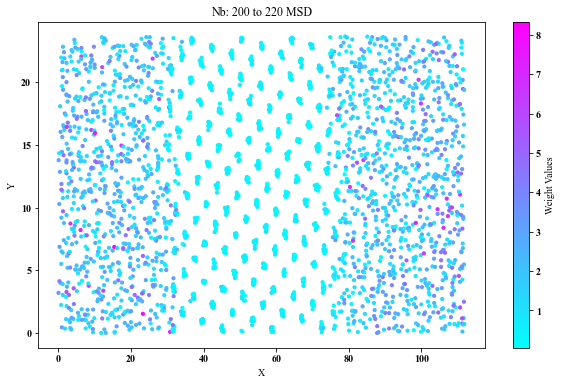

In [16]:
import matplotlib.pyplot as plt


# 假设x_list包含原子的x坐标，z_list包含原子的z坐标，cn_list包含权重值
# x_list = [1.0, 2.0, 3.0, 4.0]  # 用您的实际数据替换这些示例数据
# z_list = [0.5, 1.0, 1.5, 2.0]  # 用您的实际数据替换这些示例数据
# cn_list = [0.1, 0.5, 0.8, 0.3]  # 用您的实际数据替换这些示例数据

# 创建画布
plt.figure(figsize=(10, 6))

# 绘制二维权重值分布图
plt.scatter(x_list, y_list, c=msd, cmap='cool', s=10)

# 添加颜色栏
cbar = plt.colorbar()
cbar.set_label('Weight Values')
title = ana_element+': '+ str(start_frame_num)+' to '+ str(end_frame_num)+ ' MSD'
# 添加标题和坐标轴标签
plt.title(title)
plt.xlabel('X')
plt.ylabel('Y')

# 显示图形
plt.show()


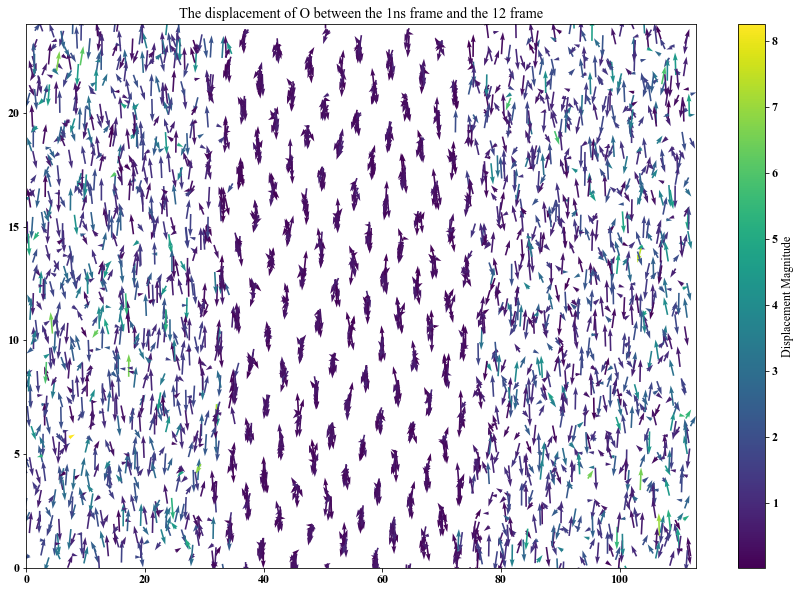

In [17]:
# 设置全局字体属性
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12


# 两帧原子的xyz数据，每一帧包含原子的位置信息
frame1 = np.array(start_xyz)
frame2 = np.array(end_xyz)

# 盒子尺寸，假设为 [box_x, box_y, box_z]
# box_size = [10.0, 10.0, 10.0]

# 计算位移向量
displacements = frame2[:, :2] - frame1[:, :2]

# 考虑周期性边界条件，根据盒子尺寸修正位移
for i in range(len(displacements)):
    for dim in range(2):  # 仅考虑 xy 平面
        if displacements[i, dim] > box_size[dim] / 2:
            displacements[i, dim] -= box_size[dim]
        elif displacements[i, dim] < -box_size[dim] / 2:
            displacements[i, dim] += box_size[dim]

# 计算位移大小和方向
displacement_magnitude = np.linalg.norm(displacements, axis=1)
displacement_direction = displacements / displacement_magnitude[:, np.newaxis]

plt.figure(figsize=(15, 10))  # 设置图像宽度为8英寸，高度为6
# 绘制位移图
plt.quiver(frame1[:, 0], frame1[:, 1], displacement_direction[:, 0], displacement_direction[:, 1], 
           displacement_magnitude, cmap='viridis', angles='xy', scale_units='xy', scale=1)

# 设置图形范围，根据盒子尺寸
plt.xlim(0, box_size[0])
plt.ylim(0, box_size[1])

plt.title('The displacement of O between the 1ns frame and the 12 frame')
# 添加颜色条
plt.colorbar(label='Displacement Magnitude')

# 显示图形
plt.show()


# 最后的结果

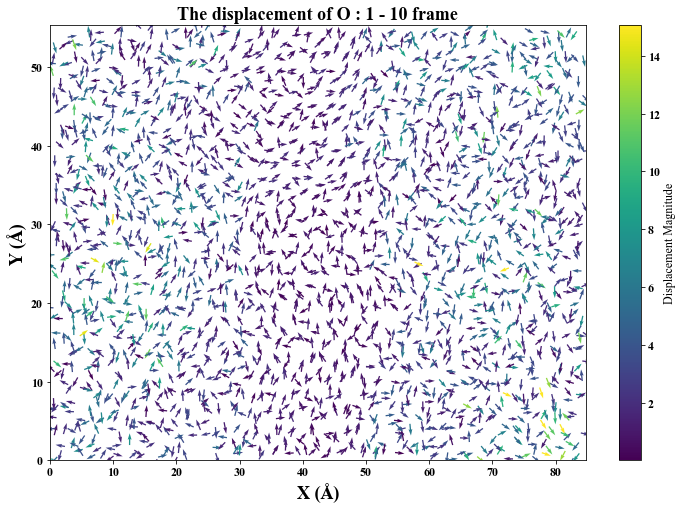

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.font_manager import FontProperties
# 设置全局字体属性
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# 设置图像大小
fig = plt.figure(figsize=(12, 8))

# 两帧原子的xyz数据，每一帧包含原子的位置信息
frame1 = np.array(start_xyz)
frame2 = np.array(end_xyz)

# 盒子尺寸，假设为 [box_x, box_y, box_z]
#box_size = [10.0, 10.0, 10.0]

# 计算位移向量
displacements = frame2[:, :2] - frame1[:, :2]

# 考虑周期性边界条件，根据盒子尺寸修正位移
for i in range(len(displacements)):
    for dim in range(2):  # 仅考虑 xy 平面
        if displacements[i, dim] > box_size[dim] / 2:
            displacements[i, dim] -= box_size[dim]
        elif displacements[i, dim] < -box_size[dim] / 2:
            displacements[i, dim] += box_size[dim]

# 计算位移大小
displacement_magnitude = np.linalg.norm(displacements, axis=1)

# 计算位移方向
displacement_direction = displacements / displacement_magnitude[:, np.newaxis]

# 设置箭头的长度的倍数
arrow_scale = 1.5  # 可以根据需要调整箭头的长度

# 设置颜色映射范围，根据位移大小来映射颜色
norm = Normalize(vmin=min(displacement_magnitude), vmax=max(displacement_magnitude))

# 绘制位移图，将位移大小与箭头长度相乘
plt.quiver(frame1[:, 0], frame1[:, 1], arrow_scale * displacement_direction[:, 0], arrow_scale * displacement_direction[:, 1], 
           arrow_scale * displacement_magnitude, cmap='viridis', angles='xy', scale_units='xy', scale=1, norm=norm)

# 
# 设置标题和轴标签的字体和字体大小，以及使用Times New Roman字体
label_font = FontProperties(family='Times New Roman', style='normal', size=18, weight='bold')


# 设置图形范围，根据盒子尺寸
plt.xlim(0, box_size[0])
plt.ylim(0, box_size[1])
plt.xlabel('X (Å)',fontproperties=label_font)
plt.ylabel('Y (Å)',fontproperties=label_font)
# 添加颜色条

title = 'The displacement of '+ ana_element+ ' : '+str(start_frame_num) +' - '+ str(end_frame_num)+' frame'
plt.title(title, fontproperties=label_font)


# 设置颜色条字体大小、粗细和字体族
cbar.ax.tick_params(labelsize=12, width=2)  # 设置字体大小和粗细
cbar.ax.yaxis.label.set_font_properties(FontProperties(family='Times New Roman', style='normal', size=12, weight='bold'))

cbar = plt.colorbar(label='Displacement Magnitude')

# 显示图形
plt.show()


In [82]:
title

'The displacement of O : 1 - 10 frame'